# Exercise 2: Traveling Salesperson Problem (TSP)
In today's lecture you learned how to derive a QUBO formulation for the Knapsack problem. There is no uniform way to derive a QUBO formulation for a general problem, but (https://arxiv.org/pdf/1302.5843.pdf) by Andrew Lucas gives a few formulations for known combinatorial optimization problems. One of them is the travelling salesperson problem (TSP), on which you will have a closer look on in this exercise.

Consider the following problem: you have to deliver a cupcake to each of your coworkers. Let your coworkers be represented as vertices on a graph. Let there be an edge matrix defining a travel time (edge cost) between every coworker (vertex) to another. How can you deliver a cupcake to each coworker, while visiting each coworker exactly once, and return to your starting location, while minimizing your travel time?

This is an NP-hard combinatorial optimization problem called the traveling salesperson problem.

Generalizing, you are faced with the following optimization problem:

you have a finite set of vertices, $V$, and an edge cost matrix, $D: V\times V\rightarrow \mathbb{R}$, defining a cost between each vertex. What is the lowest cost route possible that visits each vertex exactly once and returns to the origin vertex. 

We will write this problem as a QUBO formulation using the binary variable $x_{i,j}\in\{0,1\}$. Let $N$ be the number of vertices in the graph, $i\in\{0,...,N-1\}$, and $j\in\{0,...,N-1\}$. The index $i$ labels the vertices of the graph and $j$ represents the order of the vertices in a potential tour through the graph vertices. Such that, $x_{i,j}=1$ if vertex $i$ is visited at location $j$ in the tour, and $x_{i,j}=0$ otherwise. 

First, we will initialize our 3 vertex TSP instance for this example.

(CVXPY) Apr 27 01:39:57 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.2.9972) is too old. Expected >= 9.3.0.')
(CVXPY) Apr 27 01:39:57 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.2.9972) is too old. Expected >= 9.3.0.')
[[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


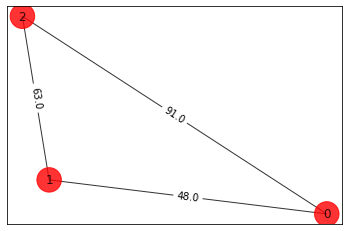

In [1]:
import numpy as np
from qiskit.optimization.applications.ising import tsp
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import networkx as nx
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
    
#N is the number of vertices in our graph
N=3
ins = tsp.random_tsp(N, seed=123)
#D is our edge cost matrix
D=np.array(ins.w)
print(D)

# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]
for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])
pos = {k: v for k, v in enumerate(ins.coord)}
draw_graph(G, colors, pos)

Homework 1.1

Given a graph G with vertices, $V={0,1,2}$. Given the tour order, $O={2,0,1}$, determine the corresponding bitstring $x\in \{0,1\}^{3\times 3}$.
<br>
$x_{0,0}=0 $<br>
$x_{0,1}=1 $<br>
$x_{0,2}=0 $<br> 
$x_{1,0}=0 $<br> 
$x_{1,1}=0 $<br> 
$x_{1,2}=1 $<br> 
$x_{2,0}=1 $<br> 
$x_{2,1}=0 $<br> 
$x_{2,2}=0 $<br> 



In [2]:
#Exercise 1.2 
#fill in the missing code, wherever ## is

#We initialize the variables to create our QUBO
from docplex.mp.model import Model
mdl = Model()
b=N ##


varlist=[]
for i in range(0,b):
    for j in range(0,b):
        varlist.append('x_'+str(i)+'_'+str(j))


for i in varlist:
    locals()[i] = mdl.binary_var(i)
    
print(varlist)

['x_0_0', 'x_0_1', 'x_0_2', 'x_1_0', 'x_1_1', 'x_1_2', 'x_2_0', 'x_2_1', 'x_2_2']


# QUBO Formulation

#### Motivation:
We need to create an objective QUBO formulation for our TSP instance. The minimum of this expression should represent the optimal solution to our TSP. Our objective will consist of three terms 
$$H=AH1+AH2+BH3,$$ 
where $A$ and $B$ are weighting factors. We will begin with the necessary constraints to guarantee a feasible solution to our problem ($H1$ and $H2$), then we will finish with the cost to be minimized ($H3$).

#### H1
Our first constraint ensures that every vertex can only appear once in a cycle, this punishes each time a vertex does not appear or appears more than once in the ordering.
$$H1 = \sum\limits_{i=0}^{N-1} (1-\sum\limits_{j=0}^{N-1} x_{i,j})^2.$$




In [3]:
#Exercise 1.3,
#fill in the missing code, wherever ## is

#Here we create our H1 term
H1=0
for i in range(0,N):
    s=1
    for j in range(0,N):
        s=s-eval('x_'+str(i)+'_'+str(j))
    s=s**2 ## 
    H1=H1+s

print(H1)

x_0_0^2+2x_0_0*x_0_1+2x_0_0*x_0_2+x_0_1^2+2x_0_1*x_0_2+x_0_2^2+x_1_0^2+2x_1_0*x_1_1+2x_1_0*x_1_2+x_1_1^2+2x_1_1*x_1_2+x_1_2^2+x_2_0^2+2x_2_0*x_2_1+2x_2_0*x_2_2+x_2_1^2+2x_2_1*x_2_2+x_2_2^2-2x_0_0-2x_0_1-2x_0_2-2x_1_0-2x_1_1-2x_1_2-2x_2_0-2x_2_1-2x_2_2+3


#### H2
For every position in the ordering one vertex must be visited, this punishes each time no vertices or more than one vertex are visited for each position in the ordering.
$$H2 = \sum\limits_{j=0}^{N-1} (1-\sum\limits_{i=0}^{N-1} x_{i,j})^2.$$

In [4]:
#Exercise 1.4,
#fill in the missing code, wherever ## is

#Here we create our H2 term

H2=0
for j in range(0,N):
    s=1  ## 
    for i in range(0,N):
        s=s-eval('x_'+str(i)+'_'+str(j))
    s=s**2
    H2=H2+s  ## 
    
print(H2)

x_0_0^2+2x_0_0*x_1_0+2x_0_0*x_2_0+x_0_1^2+2x_0_1*x_1_1+2x_0_1*x_2_1+x_0_2^2+2x_0_2*x_1_2+2x_0_2*x_2_2+x_1_0^2+2x_1_0*x_2_0+x_1_1^2+2x_1_1*x_2_1+x_1_2^2+2x_1_2*x_2_2+x_2_0^2+x_2_1^2+x_2_2^2-2x_0_0-2x_0_1-2x_0_2-2x_1_0-2x_1_1-2x_1_2-2x_2_0-2x_2_1-2x_2_2+3


#### H3
This term minimizes the sum of the weights of the tour. $D_{u,v}$ is the entry in $D$ corresponding to the edge weight between vertices $u$ and $v$. The expression in parentheses equals 1 when an edge exists between vertices $u$ and $v$, and 0 otherwise.
$$H2 = \sum\limits_{u=0}^{N-1} \sum\limits_{v=0}^{N-1} D_{u,v}(\sum\limits_{j=0}^{N-1} x_{u,j}*x_{v,j+1}).$$


In [5]:
#Exercise 1.5,
#fill in the missing code, wherever ## is

#Here we create our H3 term
H3=0
for u in range(0,N):
    for v in range(0,N):
        w=D[u,v]
        if w!=0:
            s=0
            for j in range(0,N):
                s=s+(eval('x_'+str(u)+'_'+str(j))*eval('x_'+str(v)+'_'+str((j+1)%N)))
            s=w*s ##
            H3=H3+s ## 
            
print(H3)            

48x_0_0*x_1_1+48x_0_0*x_1_2+91x_0_0*x_2_1+91x_0_0*x_2_2+48x_0_1*x_1_0+48x_0_1*x_1_2+91x_0_1*x_2_0+91x_0_1*x_2_2+48x_0_2*x_1_0+48x_0_2*x_1_1+91x_0_2*x_2_0+91x_0_2*x_2_1+63x_1_0*x_2_1+63x_1_0*x_2_2+63x_1_1*x_2_0+63x_1_1*x_2_2+63x_1_2*x_2_0+63x_1_2*x_2_1


Now we need to determine our weighting factors $A$ and $B$. We need $B$ to be smaller than $A$ so that it is never favorable to violate the $H1$ and $H2$ constraints in order to greater satisfy the $H3$ constraint. This is because $H1$ and $H2$ ensure we have a feasible solution, whereas $H3$ drives down the cost of our tour. If we prioritize $H3$ over $H1$ and $H2$ we could end up with an infeasible solution.

In [6]:
#Exercise 1.6,
#fill in the missing code, wherever ## is

#Determine the weighting factors
A=100 ##
B=1 ##

#Answer: many possible answers, correct as long as 0< B*max(Duv)< A, which for this instance max(Duv)=91
#so as long as 0< B*91< A, the answer is correct. For example, A=100 and B=1 works

In [7]:
#Exercise 1.7,
#fill in the missing code, wherever ## is

#Our final hamiltonian is...
H=(A*H1)+(A*H2)+(B*H3) ##
print(H)

200x_0_0^2+200x_0_0*x_0_1+200x_0_0*x_0_2+200x_0_0*x_1_0+48x_0_0*x_1_1+48x_0_0*x_1_2+200x_0_0*x_2_0+91x_0_0*x_2_1+91x_0_0*x_2_2+200x_0_1^2+200x_0_1*x_0_2+48x_0_1*x_1_0+200x_0_1*x_1_1+48x_0_1*x_1_2+91x_0_1*x_2_0+200x_0_1*x_2_1+91x_0_1*x_2_2+200x_0_2^2+48x_0_2*x_1_0+48x_0_2*x_1_1+200x_0_2*x_1_2+91x_0_2*x_2_0+91x_0_2*x_2_1+200x_0_2*x_2_2+200x_1_0^2+200x_1_0*x_1_1+200x_1_0*x_1_2+200x_1_0*x_2_0+63x_1_0*x_2_1+63x_1_0*x_2_2+200x_1_1^2+200x_1_1*x_1_2+63x_1_1*x_2_0+200x_1_1*x_2_1+63x_1_1*x_2_2+200x_1_2^2+63x_1_2*x_2_0+63x_1_2*x_2_1+200x_1_2*x_2_2+200x_2_0^2+200x_2_0*x_2_1+200x_2_0*x_2_2+200x_2_1^2+200x_2_1*x_2_2+200x_2_2^2-400x_0_0-400x_0_1-400x_0_2-400x_1_0-400x_1_1-400x_1_2-400x_2_0-400x_2_1-400x_2_2+600


With the objective, $H$, we created above, we now have our QUBO formulation that can be used in quantum algorithms, like QAOA or VQE, to find a solution to our TSP. Many combinatorial optimization problems can be written as QUBOs and solved/approximated with quantum algorithms. 

In [14]:
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram

objective = H
mdl.minimize(objective)
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)      

qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 400 x_0_0 - 400 x_0_1 - 400 x_0_2 - 400 x_1_0 - 400 x_1_1 - 400 x_1_2
      - 400 x_2_0 - 400 x_2_1 - 400 x_2_2 + [ 400 x_0_0^2 + 400 x_0_0*x_0_1
      + 400 x_0_0*x_0_2 + 400 x_0_0*x_1_0 + 96 x_0_0*x_1_1 + 96 x_0_0*x_1_2
      + 400 x_0_0*x_2_0 + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_2 + 400 x_0_1^2
      + 400 x_0_1*x_0_2 + 96 x_0_1*x_1_0 + 400 x_0_1*x_1_1 + 96 x_0_1*x_1_2
      + 182 x_0_1*x_2_0 + 400 x_0_1*x_2_1 + 182 x_0_1*x_2_2 + 400 x_0_2^2
      + 96 x_0_2*x_1_0 + 96 x_0_2*x_1_1 + 400 x_0_2*x_1_2 + 182 x_0_2*x_2_0
      + 182 x_0_2*x_2_1 + 400 x_0_2*x_2_2 + 400 x_1_0^2 + 400 x_1_0*x_1_1
      + 400 x_1_0*x_1_2 + 400 x_1_0*x_2_0 + 126 x_1_0*x_2_1 + 126 x_1_0*x_2_2
      + 400 x_1_1^2 + 400 x_1_1*x_1_2 + 126 x_1_1*x_2_0 + 400 x_1_1*x_2_1
      + 126 x_1_1*x_2_2 + 400 x_1_2^2 + 126 x_1_2*x_2_0 + 126 x_1_2*x_2_1
      + 400 x_1_2*x_2_2 + 400 x_2_0^2 + 400 x_2_0*x_2_1 + 400 x_2_